# Bug Detection 


In [1]:
!pip install datasets transformers sentencepiece torchmetrics

In [3]:
!pip install accelerate -U

In [7]:
import os

!pip install huggingface_hub
from huggingface_hub import notebook_login

In [9]:
import os
import json
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import RobertaTokenizerFast, T5ForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForSeq2Seq
from datasets import load_dataset

from torchmetrics import ConfusionMatrix, Accuracy, Precision, Recall, F1Score
from sklearn.preprocessing import LabelEncoder

from tqdm.notebook import tqdm
from IPython.display import HTML
from functools import partial

pd.set_option('display.max_columns', None)
codenet_root = 'dataset/'

os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Preprocess Data

In [11]:
dataset = load_dataset("json", data_files={"train": codenet_root+"train_set.json", "test": codenet_root+"test_set.json"}, field='data')

FileNotFoundError: Unable to find 'C:/Users/e.seffen/Desktop/defects4jbugs\dataset/train_set.json'

### Label Tokens

In [11]:
def tokenize_and_align_labels(tokenizer, example):
    example = {
        "input": example["input"] + example["output"], 
        "vulnerability type": example["vulnerability type"] + ["Accepted" for _ in example["output"]]
    }
    tokenized_inputs = tokenizer(example["input"], padding=True, truncation=True)#, return_tensors="pt")
    tokenized_y = tokenizer(example["vulnerability type"], padding=True, truncation=True)#, return_tensors="pt")

    tokenized_inputs["labels"] = tokenized_y.input_ids
    return tokenized_inputs

tokenizer = RobertaTokenizerFast.from_pretrained("Salesforce/codet5-base")

train_dataset = dataset["train"].train_test_split(test_size=0.1)
test_dataset = dataset["test"]

train_dataset = train_dataset.map(partial(tokenize_and_align_labels, tokenizer), batched=True, batch_size=4, remove_columns=train_dataset["train"].column_names)
test_dataset = test_dataset.map(partial(tokenize_and_align_labels, tokenizer), batched=True, batch_size=4, remove_columns=test_dataset.column_names)

C:\Users\e.seffen\AppData\Local\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/6716 [00:00<?, ? examples/s]

Map:   0%|          | 0/747 [00:00<?, ? examples/s]

## Train

### Training Setup
We load the T5 model and set the basic parameters for the trainer.

In [15]:
training_args = TrainingArguments(
    output_dir='codet5-base-buggy-error-description',          # output directory
    num_train_epochs=1,                                        # total number of training epochs
    per_device_train_batch_size=4,                             # batch size per device during training
    per_device_eval_batch_size=4,                              # batch size for evaluation
    warmup_steps=500,                                          # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                                         # strength of weight decay
    logging_dir='./logs',                                      # directory for storing logs
    logging_steps=1_000,                                       # Steps to report the loss value
    save_strategy ="no",
)

model = T5ForConditionalGeneration.from_pretrained("Salesforce/codet5-base")
data_collator = DataCollatorForSeq2Seq(tokenizer, model, padding=True)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

C:\Users\e.seffen\AppData\Local\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\e.seffen\.cache\huggingface\hub\models--Salesforce--codet5-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [17]:
def compute_metrics(p):
    predictions, labels = p
    
    predictions = np.argmax(predictions[0], axis=2)
   
    true_predictions = [p for pred in predictions for p in pred]
    true_labels = [p for pred in labels for p in pred]
    
    true_predictions1 = [pred[1] for pred in predictions]
    true_labels1 = [label[1] for label in labels]
    
    return {
        "precision": precision_score(true_labels, true_predictions, average="weighted"),
        "recall": recall_score(true_labels, true_predictions, average="weighted"),
        "f1": f1_score(true_labels, true_predictions, average="weighted"),
        "accuracy": accuracy_score(true_labels, true_predictions),
        "1_precision": precision_score(true_labels1, true_predictions1, average="weighted"),
        "1_recall": recall_score(true_labels1, true_predictions1, average="weighted"),
        "1_f1": f1_score(true_labels1, true_predictions1, average="weighted"),
        "1_accuracy": accuracy_score(true_labels1, true_predictions1),
    }

In [19]:
trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset["train"],  
    eval_dataset=train_dataset["test"].select(range(200)),    
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

trainer.train()

Step,Training Loss
1000,0.414900
2000,0.030900
3000,0.021000


TrainOutput(global_step=3358, training_loss=0.1408963359630555, metrics={'train_runtime': 1565.257, 'train_samples_per_second': 8.581, 'train_steps_per_second': 2.145, 'total_flos': 8161515310878720.0, 'train_loss': 0.1408963359630555, 'epoch': 1.0})

In [25]:
# # This did not work, OOM which does not make sense because the training works, seem related to an issue
# # https://discuss.huggingface.co/t/cuda-out-of-memory-during-evaluation-but-training-is-fine/1783/2
trainer.evaluate()

C:\Users\e.seffen\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\e.seffen\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.01904507353901863,
 'eval_precision': 0.8124309340522828,
 'eval_recall': 0.8933333333333333,
 'eval_f1': 0.848437005961392,
 'eval_accuracy': 0.8933333333333333,
 'eval_1_precision': 0.9278030303030304,
 'eval_1_recall': 0.925,
 'eval_1_f1': 0.9236121212121212,
 'eval_1_accuracy': 0.925,
 'eval_runtime': 528.8209,
 'eval_samples_per_second': 0.378,
 'eval_steps_per_second': 0.095,
 'epoch': 1.0}

In [27]:
def predict(tokenizer, model, source, beam_size=5):
    tokenized_inputs = tokenizer(source, padding=True, truncation=True, return_tensors="pt").to(model.device)
    tokenized_labels = model.generate(num_beams=beam_size, no_repeat_ngram_size=2, num_return_sequences=beam_size, **tokenized_inputs).cpu().detach().numpy()

    return tokenizer.batch_decode(tokenized_labels, skip_special_tokens=True)


def get_preds_1a(beam_sizes, total=1000, dataset=dataset["test"]):
    if total == -1:
        total = len(dataset)
    preds_1 = [[None for _ in range(total)] for _ in beam_sizes]
    preds_a = [[None for _ in range(total)] for _ in beam_sizes]
    
    for i in tqdm(range(total)):
        preds = predict(tokenizer, model, [dataset[i]["input"]], beam_size=beam_sizes[-1])

        gt = dataset[i]["vulnerability type"]
        gt_class = gt.split(":")[0]
        for j, pred in enumerate(preds):
            try:
                pred_class = pred.split(":")[0]
                for k in range(len(preds_1)):
                    if j < beam_sizes[k] and (preds_1[k][i] is None or pred_class == gt_class):
                        preds_1[k][i] = pred_class
                    if  j < beam_sizes[k] and (preds_a[k][i] is None or pred == gt):
                        preds_a[k][i] = pred
            except:
                print("Exception")
                
    return preds_a, preds_1

beam_sizes=[1, 5, 10, 50]
total=-1
preds_a, preds_1 = get_preds_1a(beam_sizes, total=total)

  0%|          | 0/830 [00:00<?, ?it/s]

C:\Users\e.seffen\AppData\Local\anaconda3\Lib\site-packages\transformers\generation\utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [37]:
ground_truth_1 = []
ground_truth = []
for i in range(len(dataset["test"]) if total == -1 else total):
    gt = dataset["test"][i]["vulnerability type"]
    ground_truth_1.append(gt.split(":")[0])
    ground_truth.append(gt)
    
classes = list(set(ground_truth_1)) + ["Accepted"]
n_classes = len(classes)

def class2idx(class_names):
    return np.array([classes.index(class_name) for class_name in class_names])

print(f"Number of classes is {n_classes}")
print(classes)

Number of classes is 8
['UNSAFE_GUARDED_BY_ACCESS', 'CHECKERS_IMMUTABLE_CAST', 'NULL_DEREFERENCE', 'CHECKERS_PRINTF_ARGS', 'THREAD_SAFETY_VIOLATION', 'RESOURCE_LEAK', 'INTERFACE_NOT_THREAD_SAFE', 'Accepted']


In [57]:
le_ground_truth_1 = class2idx(ground_truth_1)
le_ground_truth_1 = torch.from_numpy(le_ground_truth_1)

accuracy = Accuracy(num_classes=n_classes, task="multiclass")
precision = Precision(num_classes=n_classes, task="multiclass")
recall = Recall(num_classes=n_classes, task="multiclass")
f1 = F1Score(num_classes=n_classes, task="multiclass")

print("Metrics only for the first item (or the class or the error)")
for i, b in enumerate(beam_sizes):
    le_preds_1 = torch.from_numpy(class2idx(preds_1[i]))
    
    acc = accuracy(le_preds_1, le_ground_truth_1).item()
    p = precision(le_preds_1, le_ground_truth_1).item()
    r = recall(le_preds_1, le_ground_truth_1).item()
    f = f1(le_preds_1, le_ground_truth_1).item()
    
    print(f"Accuracy1 beam_size={b} {acc:.4f}")
    print(f"Precision1 beam_size={b} {p:.4f}")
    print(f"Recall1 beam_size={b} {r:.4f}")
    print(f"F11 beam_size={b} {f:.4f}")

Metrics only for the first item (or the class or the error)
Accuracy1 beam_size=1 0.8892
Precision1 beam_size=1 0.8892
Recall1 beam_size=1 0.8892
F11 beam_size=1 0.8892
Accuracy1 beam_size=5 0.9988
Precision1 beam_size=5 0.9988
Recall1 beam_size=5 0.9988
F11 beam_size=5 0.9988
Accuracy1 beam_size=10 0.9988
Precision1 beam_size=10 0.9988
Recall1 beam_size=10 0.9988
F11 beam_size=10 0.9988
Accuracy1 beam_size=50 1.0000
Precision1 beam_size=50 1.0000
Recall1 beam_size=50 1.0000
F11 beam_size=50 1.0000


In [59]:
print("Metrics for the entire error message")
for i, b in enumerate(beam_sizes):
    correct_preds = 0
    total_preds = 0
    
    for pred, gt in zip(preds_a[i], ground_truth):
        if pred == gt:
            correct_preds += 1
        total_preds += 1
    
    print(f"Accuracy beam_size={b} {correct_preds / total_preds}")

Metrics for the entire error message
Accuracy beam_size=1 0.8891566265060241
Accuracy beam_size=5 0.9987951807228915
Accuracy beam_size=10 0.9987951807228915
Accuracy beam_size=50 1.0


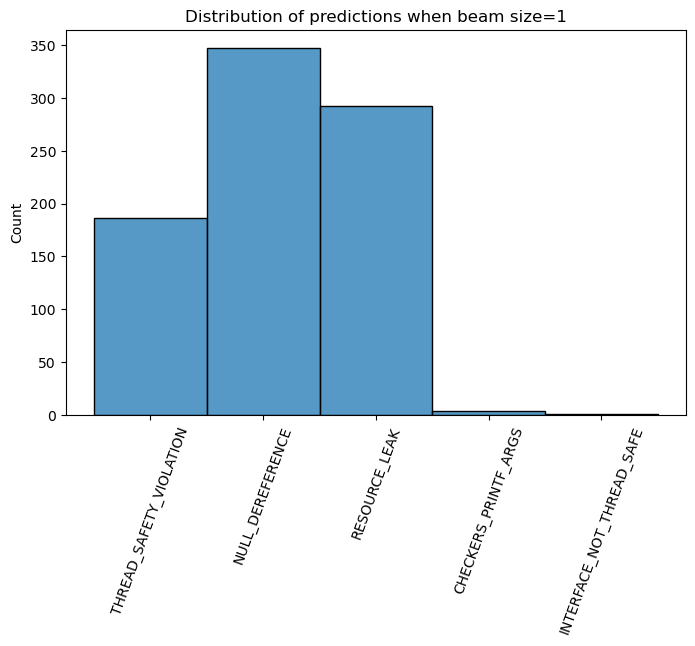

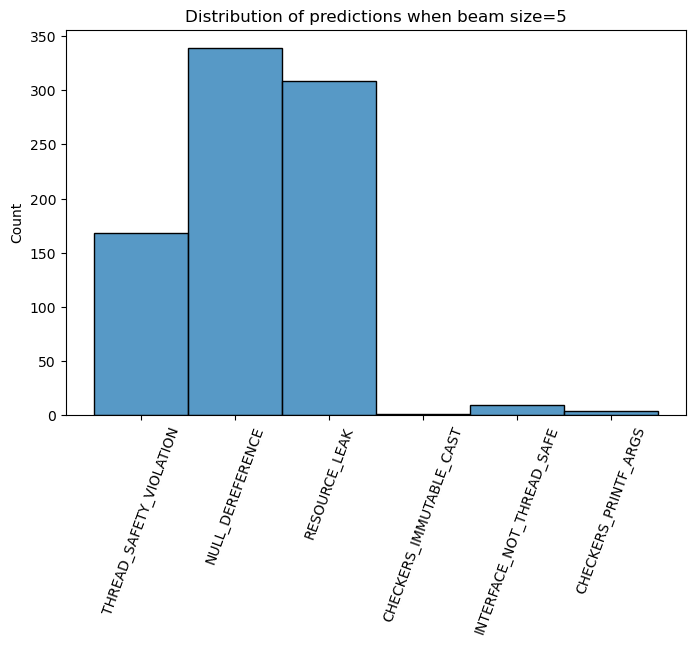

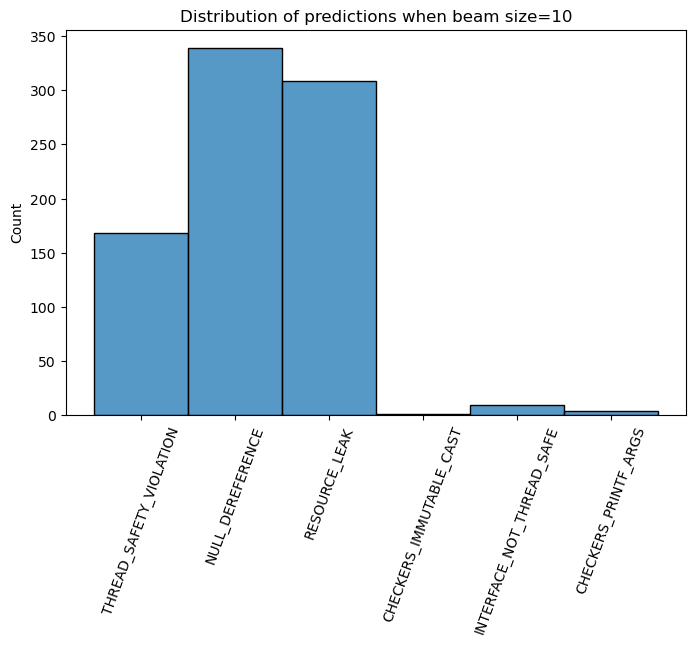

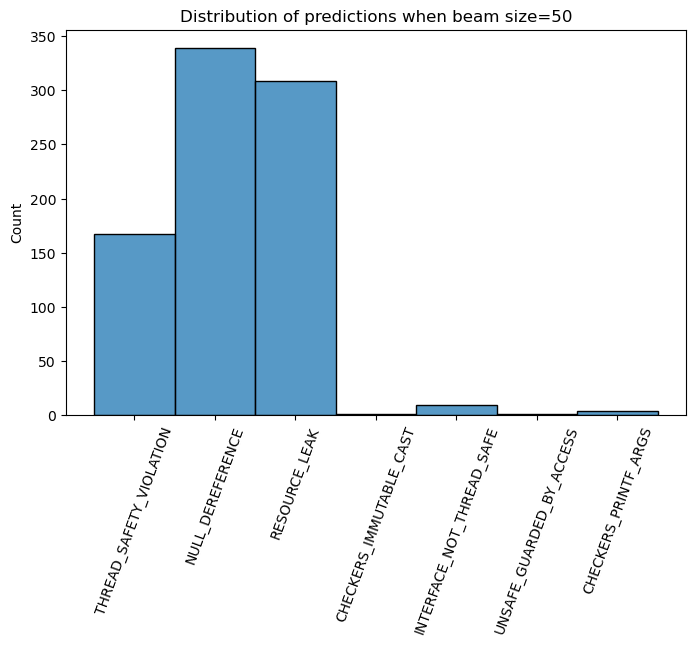

In [61]:
for i in range(len(beam_sizes)):
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.histplot(preds_1[i], ax=ax)

    plt.xticks(rotation=70)
    plt.title(f"Distribution of predictions when beam size={beam_sizes[i]}")
    plt.show()

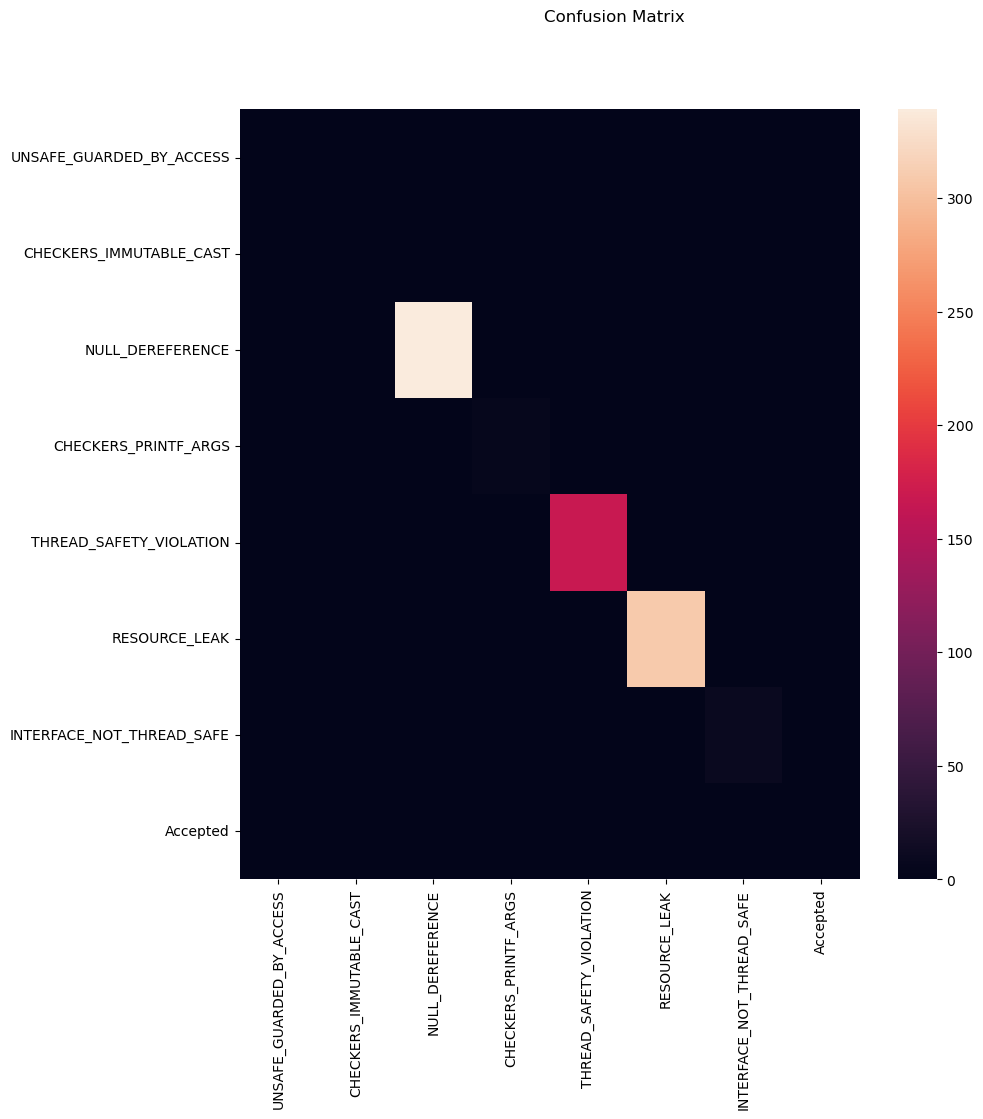

In [69]:
confmat = ConfusionMatrix(num_classes=n_classes,task="multiclass")

confmat_1 = confmat(le_preds_1, le_ground_truth_1)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data=confmat_1, xticklabels=classes, yticklabels=classes, ax=ax)
fig.suptitle("Confusion Matrix")
plt.show()

# Ground truth is on the y axes and predictions are on the x axes

In [18]:
if KAGGLE_KERNEL_INTERACTIVE:
    trainer.push_to_hub()

## Inference

In [83]:
model.save_pretrained('codet5-base-buggy-error-description')
tokenizer.save_pretrained('codet5-base-buggy-error-description')

('codet5-base-buggy-error-description\\tokenizer_config.json',
 'codet5-base-buggy-error-description\\special_tokens_map.json',
 'codet5-base-buggy-error-description\\vocab.json',
 'codet5-base-buggy-error-description\\merges.txt',
 'codet5-base-buggy-error-description\\added_tokens.json',
 'codet5-base-buggy-error-description\\tokenizer.json')

In [71]:
def predict(tokenizer, model, source, beam_size=5):
    tokenized_inputs = tokenizer(source, padding=True, truncation=True, return_tensors="pt").to(model.device)
    tokenized_labels = model.generate(num_beams=beam_size, no_repeat_ngram_size=2, num_return_sequences=beam_size, **tokenized_inputs).cpu().detach().numpy()

    return tokenizer.batch_decode(tokenized_labels, skip_special_tokens=True)

In [93]:
from transformers import T5ForConditionalGeneration,RobertaTokenizer
model_path = 'codet5-base-buggy-error-description'
model = T5ForConditionalGeneration.from_pretrained(model_path)
tokenizer =RobertaTokenizer.from_pretrained(model_path)
for i in range(50):
    display(HTML(f"<h2>Example {i}</h2>"))
    print(dataset["test"][i]["input"])
    print(dataset["test"][i]["vulnerability type"])
    print(predict(tokenizer, model, [dataset["test"][i]["input"]])[0])

@Override
    public void reset() {
        result = null;
    }
THREAD_SAFETY_VIOLATION
THREAD_SAFETY_VIOLATION


@Test
	public void testAddWorkdaysFromFriday() {
	
		Calendar startDate = Calendar.getInstance();
		// adjust to FRIDAY
		startDate.set(Calendar.DAY_OF_WEEK, Calendar.FRIDAY);
		System.out.println("Startdate=" + startDate.getTime());
	
		// adjust -3 Workdays -> THUSEDAY
		Assert.assertEquals(Calendar.TUESDAY,
				WorkflowSchedulerService.addWorkDays(startDate, 2).get(Calendar.DAY_OF_WEEK));
	
		Assert.assertEquals(Calendar.WEDNESDAY,
				WorkflowSchedulerService.addWorkDays(startDate, 8).get(Calendar.DAY_OF_WEEK));
	
		Assert.assertEquals(Calendar.FRIDAY,
				WorkflowSchedulerService.addWorkDays(startDate, 10).get(Calendar.DAY_OF_WEEK));
	
		Assert.assertEquals(Calendar.THURSDAY,
				WorkflowSchedulerService.addWorkDays(startDate, 14).get(Calendar.DAY_OF_WEEK));
	
	}
NULL_DEREFERENCE
NULL_DEREFERENCE


@Override
  public void handleDataDeleted(String dataPath) {
    if (_zkClientForListener == null || _zkClientForListener.isClosed()) {
      return;
    }
    // Resubscribe
    _zkClientForListener.unsubscribeAll();
    _zkClientForListener.subscribeRoutingDataChanges(this, this);
    resetZkResources();
  }
THREAD_SAFETY_VIOLATION
THREAD_SAFETY_VIOLATION


public static String exec(String cmd) throws IOException {
        Process process = Runtime.getRuntime().exec(cmd);
        InputStream inputStream = process.getInputStream();
        InputStream errorStream = process.getErrorStream();
        try {
            String err = IOUtils.toString(errorStream, "UTF-8");
            String out = IOUtils.toString(inputStream, "UTF-8");
            return err + "\n" + out;
        } finally {
            inputStream.close();
            errorStream.close();
        }
    }
RESOURCE_LEAK
RESOURCE_LEAK


@Test
    public void testResponseContentOverwriteHeaders() throws Exception {
        ResponseContent interceptor = new ResponseContent(true);
        HttpContext context = new BasicHttpContext(null);
        HttpResponse response = new BasicHttpResponse(HttpVersion.HTTP_1_1, HttpStatus.SC_OK, "OK");
        response.addHeader(new BasicHeader(HTTP.CONTENT_LEN, "10"));
        response.addHeader(new BasicHeader(HTTP.TRANSFER_ENCODING, "whatever"));
        interceptor.process(response, context);
        Assert.assertEquals("0", response.getFirstHeader(HTTP.CONTENT_LEN).getValue());
        Assert.assertEquals("whatever", response.getFirstHeader(HTTP.TRANSFER_ENCODING).getValue());
    }
NULL_DEREFERENCE
NULL_DEREFERENCE


@Test
	public void evolutionVCard() throws Exception {
		VCardReader reader = new VCardReader(new InputStreamReader(getClass().getResourceAsStream("John_Doe_EVOLUTION.vcf")));
		reader.setCompatibilityMode(CompatibilityMode.EVOLUTION);
		VCard vcard = reader.readNext();

		//VERSION
		assertEquals(VCardVersion.V3_0, vcard.getVersion());

		//URL
		{
			Iterator<UrlType> it = vcard.getUrls().iterator();

			UrlType t = it.next();
			assertEquals("http://www.ibm.com", t.getValue());
			assertEquals("0abc9b8d-0845-47d0-9a91-3db5bb74620d", t.getSubTypes().getFirst("X-COUCHDB-UUID"));

			assertFalse(it.hasNext());
		}

		//TEL
		{
			Iterator<TelephoneType> it = vcard.getTelephoneNumbers().iterator();

			TelephoneType t = it.next();
			assertEquals("905-666-1234", t.getValue());
			Set<TelephoneTypeParameter> types = t.getTypes();
			assertEquals(1, types.size());
			assertTrue(types.contains(TelephoneTypeParameter.CELL));
			assertEquals("c2fa1caa-2926-4087-8971-609cfc7354ce", t.getSubTy

@Test
	public void testIndexesAreSuccessfullyAsserted() {

		createLoginConstraint();

		Components.getConfiguration().setAutoIndex("assert");

		AutoIndexManager indexManager = new AutoIndexManager(metaData, Components.driver());
		assertEquals(AutoIndexMode.ASSERT.getName(), Components.getConfiguration().getAutoIndex());
		assertEquals(1, indexManager.getIndexes().size());
		indexManager.build();

		dropLoginConstraint();
	}
NULL_DEREFERENCE
NULL_DEREFERENCE


@Override
    public Raft.VoteResponse requestVote(Raft.VoteRequest request) {
        if (request.getTerm() > raftNode.getCurrentTerm()) {
            LOG.info("Received RequestVote request from server {} " +
                    "in term {} (this server's term was {})",
                    request.getServerId(), request.getTerm(),
                    raftNode.getCurrentTerm());
            raftNode.stepDown(request.getTerm());
        }
        if (request.getTerm() == raftNode.getCurrentTerm()) {
            if ((raftNode.getVotedFor() == 0
                    || raftNode.getVotedFor() == request.getServerId())
                    && (raftNode.getCurrentTerm() == request.getTerm()
                    && raftNode.getCommitIndex() == request.getLastLogIndex())) {
                raftNode.setVotedFor(request.getServerId());
                raftNode.stepDown(raftNode.getCurrentTerm());
                raftNode.resetElectionTimer();
                raftNode.updateMetaData();
             

@Override
    public void forEachRemaining(Consumer<? super E> action) {
        Objects.requireNonNull(action);
        if (!exhausted) {
            exhausted = true;
            ReentrantLock lock = queueLock;
            Object p = current;
            current = null;
            do {
                E e = null;
                lock.lock();
                try {
                    if (p != null || (p = getQueueFirst(queue)) != null)
                        do {
                            e = getNodeItem(p);
                            p = succ(p);
                        } while (e == null && p != null);
                } finally {
                    // checkInvariants();
                    lock.unlock();
                }
                if (e != null)
                    action.accept(e);
            } while (p != null);
        }
    }
THREAD_SAFETY_VIOLATION
THREAD_SAFETY_VIOLATION


protected Properties getProperties() {
		if (propertyFile!=null) { 
			Properties properties = new Properties(); // TODO: should we "inherit" from the ant projects properties ?
			try {
				properties.load(new FileInputStream(propertyFile) );
				return properties;
			} 
			catch (FileNotFoundException e) {
				throw new BuildException(propertyFile + " not found.",e);					
			} 
			catch (IOException e) {
				throw new BuildException("Problem while loading " + propertyFile,e);				
			}		
		} else {
			return null;
		}
	}
RESOURCE_LEAK
RESOURCE_LEAK


@Test
    public void testEmptyLineBehaviourCSV() throws Exception {
        String[] codes = {
                "hello,\r\n\r\n\r\n",
                "hello,\n\n\n",
                "hello,\"\"\r\n\r\n\r\n",
                "hello,\"\"\n\n\n"
        };
        String[][] res = {
                {"hello", ""}  // CSV format ignores empty lines
        };
        for (String code : codes) {
            CSVParser parser = new CSVParser(new StringReader(code));
            String[][] tmp = parser.getRecords();
            assertEquals(res.length, tmp.length);
            assertTrue(tmp.length > 0);
            for (int i = 0; i < res.length; i++) {
                assertTrue(Arrays.equals(res[i], tmp[i]));
            }
        }
    }
NULL_DEREFERENCE
RESOURCE_LEAK


@Test
  public void testConfigure() throws Exception {
    double epsilon = 0.000000000000001 ;
    Settings nsgaIISettings = new NSGAIIBinarySettings("ZDT5");
    Algorithm algorithm = nsgaIISettings.configure() ;
    Problem problem = new ZDT5("Binary") ;

    SinglePointCrossover crossover = (SinglePointCrossover)algorithm.getOperator("crossover") ;
    double pc = (Double)crossover.getParameter("probability") ;
    BitFlipMutation mutation = (BitFlipMutation)algorithm.getOperator("mutation") ;
    double pm = (Double)mutation.getParameter("probability") ;

    assertEquals("NSGAIIBinary_SettingsTest", 100, ((Integer)algorithm.getInputParameter("populationSize")).intValue());
    assertEquals("NSGAIIBinary_SettingsTest", 25000, ((Integer)algorithm.getInputParameter("maxEvaluations")).intValue());

    assertEquals("NSGAIIBinary_SettingsTest", 0.9, pc, epsilon);
    assertEquals("NSGAIIBinary_SettingsTest", 1.0/problem.getNumberOfBits(), pm, epsilon);
  }
NULL_DEREFERENCE
NULL_DEREFE

@Test
    public void testSkipPastEnd() throws Throwable {
        InputStream ins = new ByteArrayInputStream(StringUtils.getBytesIso8859_1(ENCODED_B64));
        Base64InputStream b64stream = new Base64InputStream(ins);
        // due to CODEC-130, skip now skips correctly decoded characters rather than encoded
        assertEquals(6, b64stream.skip(10));
        // End of stream reached
        assertEquals(-1, b64stream.read());
        assertEquals(-1, b64stream.read());
    }
RESOURCE_LEAK
RESOURCE_LEAK


@Override
    public List<String> getURLsFromPage(Document doc) {
        List<String> result = new ArrayList<>();
        if (getHost().contains("www.totempole666.com")
                || getHost().contains("buttsmithy.com")
                || getHost().contains("themonsterunderthebed.net")
                || getHost().contains("prismblush.com")
                || getHost().contains("www.konradokonski.com")
                || getHost().contains("thisis.delvecomic.com")
                || getHost().contains("tnbtu.com")) {
            Element elem = doc.select("div.comic-table > div#comic > a > img").first();
            // If doc is the last page in the comic then elem.attr("src") returns null
            // because there is no link <a> to the next page
            if (elem == null) {
                elem = doc.select("div.comic-table > div#comic > img").first();
            }
            // Check if this is a site where we can get the page number from the title
            if (url.to

@Test
    public void testClear() {
        Assert.assertEquals(100, trie.get("杨尚川"), 0);
        Assert.assertEquals(1, trie.get("中华人民共和国"), 0);
        trie.clear();
        Assert.assertEquals(null, trie.get("杨尚川"));
        Assert.assertEquals(null, trie.get("中华人民共和国"));
    }
NULL_DEREFERENCE
NULL_DEREFERENCE


@SuppressWarnings("unchecked")
    protected QueryPlan compileJoinQuery(StatementContext context, List<Object> binds, JoinTable joinTable, boolean asSubquery, boolean projectPKColumns, List<OrderByNode> orderBy) throws SQLException {
        byte[] emptyByteArray = new byte[0];
        List<JoinSpec> joinSpecs = joinTable.getJoinSpecs();
        if (joinSpecs.isEmpty()) {
            Table table = joinTable.getTable();
            SelectStatement subquery = table.getAsSubquery(orderBy);
            if (!table.isSubselect()) {
                context.setCurrentTable(table.getTableRef());
                PTable projectedTable = table.createProjectedTable(!projectPKColumns, context);
                TupleProjector.serializeProjectorIntoScan(context.getScan(), new TupleProjector(projectedTable));
                context.setResolver(FromCompiler.getResolverForProjectedTable(projectedTable, context.getConnection(), subquery.getUdfParseNodes()));
                table.projectColumns(context.g

public synchronized Scoreboard getScoreboard() {
        if (this.scoreboard == null) {
            this.scoreboard = Bukkit.getScoreboardManager().getNewScoreboard();
        }

        return this.scoreboard;
    }
NULL_DEREFERENCE
NULL_DEREFERENCE


@Override
  public void handleNewSession(String sessionId) {
    if (_zkClientForListener == null || _zkClientForListener.isClosed()) {
      return;
    }
    // Resubscribe
    _zkClientForListener.unsubscribeAll();
    _zkClientForListener.subscribeRoutingDataChanges(this, this);
    resetZkResources();
  }
THREAD_SAFETY_VIOLATION
THREAD_SAFETY_VIOLATION


public void downloadObject(File targetFile, DownloadInstructions downloadInstructions) {
        new DownloadObjectToFileCommand(getAccount(), getClient(), getAccess(), this, downloadInstructions, targetFile).call();
    }
RESOURCE_LEAK
RESOURCE_LEAK


public void next() {
		if (_waitingToEmit.isEmpty()) {

			fill();
		}

		while (true) {
			MessageAndOffset msgAndOffset = _waitingToEmit.pollFirst();
			
			if (msgAndOffset != null) {
				
				Long key = msgAndOffset.offset();
				Message msg = msgAndOffset.message();


				try {
					_lastEnquedOffset = key;
					if (_lastEnquedOffset > _lastComittedOffset) {

						if (msg.payload() != null) {
							
							synchronized (_receiver) {
								 _receiver.store(new String(Utils.toByteArray(msg.payload())));
							}
							 LOG.info("Store for topic " + _topic + " for partition " + _partition.partition + " is : "+  _lastEnquedOffset);

						}
					}
				} catch (Exception e) {
					LOG.info("Process Failed for offset " + key + " for  "
							+ _partition + " for topic " + _topic
							+ " with Exception" + e.getMessage());
					e.printStackTrace();
				}
			}else{
				
				break;
			}
		}

		long now = System.currentTimeMillis();
		if ((_lastEnquedOffset > _lastComittedOffset) &&

@Override
  public void visitAssignmentExpression(AssignmentExpressionTree assignment) {
    SyntaxToken lastToken = ((PHPTree) assignment.variable()).getLastToken();
    String variableName = lastToken.text();
    checkVariable(lastToken, variableName, assignment.value());
    super.visitAssignmentExpression(assignment);
  }
NULL_DEREFERENCE
NULL_DEREFERENCE


@BeforeClass
    public static void setupClass() throws Exception {
        // MockContextFactory becomes the primary JNDI provider
        final StatusConsoleListener l = new StatusConsoleListener(Level.ERROR);
        StatusLogger.getLogger().registerListener(l);
        MockContextFactory.setAsInitial();
        context = new InitialContext();
        context.rebind(FACTORY_NAME, new QueueConnectionFactoryImpl() );
        context.rebind(QUEUE_NAME, new MockQueue(QUEUE_NAME));
        ((LoggerContext) LogManager.getContext()).reconfigure();
        receiver = new JmsQueueReceiver(FACTORY_NAME, QUEUE_NAME, null, null);
    }
RESOURCE_LEAK
RESOURCE_LEAK


public Object execute(Object ctx, Map tokens, TemplateRegistry registry) {

        if (nodes == null) {
            return new String(expression);
        }
        else if (nodes.length == 2) {
            /**
             * This is an optimization for property expressions.
             */
            switch (nodes[0].getToken()) {
                case PROPERTY_EX:
                    //noinspection unchecked
                    if (CACHE_DISABLE || !cacheAggressively) {
                        char[] seg = new char[expression.length - 3];
                        //      arraycopy(expression, 2, seg, 0, seg.length);
                        for (int i = 0; i < seg.length; i++)
                            seg[i] = expression[i + 2];

                        return MVEL.eval(seg, ctx, tokens);
                    }
                    else {
                        String s = new String(expression, 2, expression.length - 3);
                        if (!EX_PRECOMP_CACHE.containsKey(s)) 

protected void manage(Architecture arch, String version) {
        httpClient = new HttpClient(config());
        try (HttpClient wdmHttpClient = httpClient) {
            downloader = new Downloader(getDriverManagerType());
            urlFilter = new UrlFilter();

            boolean getLatest = isVersionLatest(version);
            boolean cache = config().isForceCache();

            if (getLatest) {
                Optional<String> optionalBrowserVersion = config()
                        .isAvoidAutoVersion() ? empty() : getBrowserVersion();
                if (optionalBrowserVersion.isPresent()) {
                    String browserVersion = optionalBrowserVersion.get();
                    preferenceKey = getDriverManagerType().name().toLowerCase()
                            + browserVersion;
                    if (getLatest && !config.isOverride()
                            && !config().isAvoidAutoVersion()
                            && !config().isAvoidPreferences() && pre

@Override
    public List<IScanIssue> doActiveScan(IHttpRequestResponse baseRequestResponse, IScannerInsertionPoint insertionPoint) {
    	    	
    	List<IScanIssue> issues = new ArrayList<IScanIssue>();
    	stdout.println(insertionPoint.getBaseValue());
    	// Full body insertion point
    	byte[] request = baseRequestResponse.getRequest();
    	IRequestInfo requestInfo = helpers.analyzeRequest(request);
    	int bodyOffset = requestInfo.getBodyOffset();
    	int magicPos = helpers.indexOf(request, serializeMagic, false, 0, request.length);
    	int magicPosBase64 = helpers.indexOf(request, base64Magic, false, 0, request.length);
    	int magicPosAsciiHex = helpers.indexOf(request, asciiHexMagic, false, 0, request.length);
        int magicPosBase64Gzip = helpers.indexOf(request, base64GzipMagic, false, 0, request.length);
        int magicPosGzip = helpers.indexOf(request, gzipMagic, false, 0, request.length);
    	
  //   	if((magicPos > -1 && magicPos >= bodyOffset) || (magicPos

@Override
  public void process(ClusterEvent event) throws Exception
  {
    ClusterDataCache cache = event.getAttribute("ClusterDataCache");
    Map<String, IdealState> idealStates = cache.getIdealStates();

    Map<String, ResourceGroup> resourceGroupMap = new LinkedHashMap<String, ResourceGroup>();

    if (idealStates != null && idealStates.size() > 0)
    {
      for (IdealState idealState : idealStates.values())
      {
      	Set<String> resourceSet = idealState.getResourceKeySet();
      	String resourceGroupName = idealState.getResourceGroup();

          for (String resourceKey : resourceSet)
          {
            addResource(resourceKey, resourceGroupName, resourceGroupMap);
            ResourceGroup resourceGroup = resourceGroupMap
                .get(resourceGroupName);
            resourceGroup.setStateModelDefRef(idealState.getStateModelDefRef());
          }

      }
    }
    // It's important to get resourceKeys from CurrentState as well since the
    // idealState

public static void main(String ... args) throws InterruptedException, ExecutionException, TimeoutException {
        RpcServer server = createServer();
        server.start();

        RpcClient client = createClient();

        Request request = Request.newBuilder()
                .withContentType("text/plain")
                .withBody("Johnny".getBytes(Charset.forName("UTF-8")))
                .withCorrelationId(UUID.randomUUID().toString())
                .build();

        CompletableFuture<Response> future = client.call(request);

        Response response = future.get(20, TimeUnit.SECONDS);
        System.out.println("Responded -> " + new String(response.getBody()));

        client.shutdown();
        server.shutdown();

        System.exit(0);
    }
RESOURCE_LEAK
RESOURCE_LEAK


public Result<TokenInfo> getTokenInfo(String accessToken) {
    List<NameValuePair> params = new ArrayList<NameValuePair>();
    weibo.addParameter(params, "access_token", accessToken);
    String result = weibo.post("https://api.weibo.com/oauth2/get_token_info", params);
    return Result.perse(result, TokenInfo.class);
  }
NULL_DEREFERENCE
NULL_DEREFERENCE


protected List<URL> getCandidateUrls(String driverVersion)
            throws IOException {
        List<URL> urls = getDrivers();
        List<URL> candidateUrls;
        log.trace("All URLs: {}", urls);
        boolean getLatest = isUnknown(driverVersion);
        Architecture arch = config().getArchitecture();
        boolean continueSearchingVersion;

        do {
            // Get the latest or concrete version
            String shortDriverName = getShortDriverName();
            candidateUrls = getLatest ? checkLatest(urls, shortDriverName)
                    : getVersion(urls, shortDriverName, driverVersion);
            log.trace("Candidate URLs: {}", candidateUrls);
            if (versionToDownload == null) {
                break;
            }

            // Filter by OS
            if (!getDriverName().equalsIgnoreCase("IEDriverServer")
                    && !getDriverName()
                            .equalsIgnoreCase("selenium-server-standalone")) {
               

OriginateResult originate(final EndPoint local, final EndPoint target, final HashMap<String, String> myVars,
            final CallerID callerID, final Integer timeout, final boolean hideCallerId, final String context)
    {
        OriginateBaseClass.logger.debug("originate called");
        this.originateSeen = false;
        this.channelSeen = false;

        if (this.hungup == true)
        {
            // the monitored channel already hungup so just return false and
            // shutdown
            return null;
        }

        OriginateBaseClass.logger.debug("originate connection endPoint \n" + local + " to endPoint " + target //$NON-NLS-2$
                + " vars " + myVars);
        ManagerResponse response = null;

        final AsteriskSettings settings = PBXFactory.getActiveProfile();

        final OriginateAction originate = new OriginateAction();
        this.originateID = originate.getActionId();

        channelId = "" + (System.currentTimeMillis() / 1000) + ".AJ

public String getBeanId() {
		Class<?> factoryClass = objectFactory(destObjClass).getClass();
		Class<?> destClass = null;
		String methodName = "create" + destObjClass.substring(destObjClass.lastIndexOf(".") + 1) + StringUtils.capitalize(destFieldName);

		try {
			Method method = ReflectionUtils.findAMethod(factoryClass, methodName);
			Class<?>[] parameterTypes = method.getParameterTypes();
			for (Class<?> parameterClass : parameterTypes) {
				destClass = parameterClass;
				break;
			}
		} catch (NoSuchMethodException e) {
			MappingUtils.throwMappingException(e);
		}

		return destClass.getCanonicalName();
	}
NULL_DEREFERENCE
NULL_DEREFERENCE


@Test
  public void test2() throws JMException {
    double epsilon = 0.000000000000001;
    Settings GDE3Settings = new GDE3_Settings("Fonseca");
    Algorithm algorithm = GDE3Settings.configure(configuration_);
    //Problem problem = new Fonseca("Real");

    DifferentialEvolutionCrossover crossover = (DifferentialEvolutionCrossover)algorithm.getOperator("crossover") ;
    double CR = (Double)crossover.getParameter("CR") ;
    double F = (Double)crossover.getParameter("F") ;

    Assert.assertEquals("GDE3_SettingsTest", 100, ((Integer)algorithm.getInputParameter("populationSize")).intValue());
    Assert.assertEquals("GDE3_SettingsTest", 250, ((Integer)algorithm.getInputParameter("maxIterations")).intValue());

    Assert.assertEquals("GDE3_SettingsTest", 0.5, CR, epsilon);
    Assert.assertEquals("GDE3_SettingsTest", 0.5, F, epsilon);
  }
NULL_DEREFERENCE
NULL_DEREFERENCE


public <T> MappingIterator<T> readValues(byte[] src, int offset, int length)
        throws IOException, JsonProcessingException
    {
        if (_dataFormatReaders != null) {
            return _detectBindAndReadValues(_dataFormatReaders.findFormat(src, offset, length), false);
        }
        return _bindAndReadValues(considerFilter(_parserFactory.createParser(src)));
    }
RESOURCE_LEAK
RESOURCE_LEAK


@Override
    @SuppressWarnings("unchecked")
    public boolean retainAll(Collection<?> c) {
        this.clear();
        Iterator<? extends Model> iterator = (Iterator<? extends Model>) c
                .iterator();
        boolean success = true;
        while (iterator.hasNext()) {
            T element = (T) iterator.next();
            success &= internalAdd(element, false);
        }
        refreshStorage(true);
        return success;
    }
THREAD_SAFETY_VIOLATION
THREAD_SAFETY_VIOLATION


public void testCodingBeyondContentLimitFile() throws Exception {
        ReadableByteChannel channel = new ReadableByteChannelMockup(
                new String[] {
                        "stuff;", 
                        "more stuff; and a lot more stuff"}, "US-ASCII"); 
        HttpParams params = new BasicHttpParams();
        
        SessionInputBuffer inbuf = new SessionInputBufferImpl(1024, 256, params); 
        HttpTransportMetricsImpl metrics = new HttpTransportMetricsImpl();
        LengthDelimitedDecoder decoder = new LengthDelimitedDecoder(
                channel, inbuf, metrics, 16); 
        
        File fileHandle = File.createTempFile("testFile", ".txt");
        RandomAccessFile testfile  = new RandomAccessFile(fileHandle, "rw");
        FileChannel fchannel = testfile.getChannel();
        
        long bytesRead = decoder.transfer(fchannel, 0, 6);
        assertEquals(6, bytesRead);
        assertFalse(decoder.isCompleted());
        
        bytesRead = decode

@Test
	public void write_example2() throws Throwable {
		//see: RFC 6321 p.51
		VTimezone usEasternTz;
		ICalendar ical = new ICalendar();
		ical.getProperties().clear();
		ical.setProductId("-//Example Inc.//Example Client//EN");
		ical.setVersion(Version.v2_0());
		{
			usEasternTz = new VTimezone(null);
			usEasternTz.setLastModified(utcFormatter.parse("2004-01-10T03:28:45"));
			usEasternTz.setTimezoneId("US/Eastern");
			{
				DaylightSavingsTime daylight = new DaylightSavingsTime();
				daylight.setDateStart(localFormatter.parse("2000-04-04T02:00:00")).setLocalTime(true);

				RecurrenceRule rrule = new RecurrenceRule(Frequency.YEARLY);
				rrule.addByDay(1, DayOfWeek.SUNDAY);
				rrule.addByMonth(4);
				daylight.setRecurrenceRule(rrule);

				daylight.addTimezoneName("EDT");
				daylight.setTimezoneOffsetFrom(-5, 0);
				daylight.setTimezoneOffsetTo(-4, 0);

				usEasternTz.addDaylightSavingsTime(daylight);
			}
			{
				StandardTime standard = new StandardTime();
				standard.

protected void reset() {
        config().reset();
        mirrorLog = false;
        versionToDownload = null;
        forcedArch = false;
        forcedOs = false;
        retryCount = 0;
        isSnap = false;
    }
THREAD_SAFETY_VIOLATION
THREAD_SAFETY_VIOLATION


private List<String> readContractList() {
        return ResourceLoader
            .getBufferedReader(getClass(), SLA_CONTRACTS_LIST)
            .lines()
            .filter(l -> !l.startsWith("#"))
            .filter(l -> !l.trim().isEmpty())
            .collect(toList());
    }
RESOURCE_LEAK
RESOURCE_LEAK


@Override
    public BranchStatus branchRollback(BranchType branchType, String xid, long branchId, String resourceId,
                                       String applicationData) throws TransactionException {
        try {
            BranchRollbackRequest request = new BranchRollbackRequest();
            request.setXid(xid);
            request.setBranchId(branchId);
            request.setResourceId(resourceId);
            request.setApplicationData(applicationData);
            request.setBranchType(branchType);

            GlobalSession globalSession = SessionHolder.findGlobalSession(xid);
            if (globalSession == null) {
                return BranchStatus.PhaseTwo_Rollbacked;
            }

            if (BranchType.SAGA.equals(branchType)) {

                Map<String, Channel> channels = ChannelManager.getRmChannels();
                if (channels == null || channels.size() == 0) {
                    LOGGER.error(
                        "Failed to rollback SAGA

@Test
    public void determinesItemCSourceSetter() {
        Target target = new Target();

        target.setItemC( new ItemC() );

        SourceWithItemC source = new SourceWithItemC();
        GenericsHierarchyMapper.INSTANCE.intoSourceWithItemC( target, source );

        assertThat( source.getItem().typeParameterIsResolvedToItemC() ).isTrue();
    }
NULL_DEREFERENCE
NULL_DEREFERENCE


public void testReadLookahead2() throws Exception {
        char[] ref = new char[5];
        char[] res = new char[5];

        ExtendedBufferedReader br = getEBR("");
        assertEquals(0, br.read(res, 0, 0));
        assertTrue(Arrays.equals(res, ref));

        br = getEBR("abcdefg");
        ref[0] = 'a';
        ref[1] = 'b';
        ref[2] = 'c';
        assertEquals(3, br.read(res, 0, 3));
        assertTrue(Arrays.equals(res, ref));
        assertEquals('c', br.readAgain());

        assertEquals('d', br.lookAhead());
        ref[4] = 'd';
        assertEquals(1, br.read(res, 4, 1));
        assertTrue(Arrays.equals(res, ref));
        assertEquals('d', br.readAgain());

    }
RESOURCE_LEAK
RESOURCE_LEAK


@Before
    public void setUp() throws Exception {
        String content = File2String.read("init.xml");
        handler = new InitMsgXmlHandler(content);
    }
NULL_DEREFERENCE
NULL_DEREFERENCE


@Override
    public void doFilter(final Logbook logbook, final HttpServletRequest httpRequest,
            final HttpServletResponse httpResponse, final FilterChain chain) throws ServletException, IOException {

        final TeeRequest request = new TeeRequest(httpRequest);
        final TeeResponse response = new TeeResponse(httpResponse);

        chain.doFilter(request, response);

        if (isUnauthorized(response)) {
            final Optional<Correlator> correlator;

            if (isFirstRequest(request)) {
                correlator = logbook.write(new UnauthorizedRawHttpRequest(request));
            } else {
                correlator = readCorrelator(request);
            }

            if (correlator.isPresent()) {
                correlator.get().write(response);
            }
        }
    }
RESOURCE_LEAK
RESOURCE_LEAK


@Test
    public void parse() {
        Map<String,RouteParameter> params;
        RouteParameter param;
        
        // no named parameters is null
        params = RouteParameter.parse("/user");
        assertThat(params, is(nullValue()));
        
        params = RouteParameter.parse("/user/{id}/{email: [0-9]+}");
        
        param = params.get("id");
        assertThat(param.getName(), is("id"));
        assertThat(param.getToken(), is("{id}"));
        assertThat(param.getRegex(), is(nullValue()));
        
        param = params.get("email");
        assertThat(param.getName(), is("email"));
        assertThat(param.getToken(), is("{email: [0-9]+}"));
        assertThat(param.getRegex(), is("[0-9]+"));
    }
NULL_DEREFERENCE
NULL_DEREFERENCE


@Test
    void resolveFieldOfEnumAsInternalClassOfClassUnqualifiedDifferentPackage() throws IOException {
        File src = new File("src/test/resources/enumLiteralsInAnnotatedClass");
        File aClass = new File(src.getPath() + File.separator + "foo" + File.separator + "bar"
                + File.separator + "differentpackage" + File.separator + "AClass2.java");

        CombinedTypeSolver localCts = new CombinedTypeSolver();
        localCts.add(new ReflectionTypeSolver());
        localCts.add(new JavaParserTypeSolver(src));

        ParserConfiguration parserConfiguration = new ParserConfiguration().setSymbolResolver(new JavaSymbolSolver(localCts));
        JavaParser parser = new JavaParser(parserConfiguration);
        StreamProvider classProvider = new StreamProvider(new FileInputStream(aClass));

        CompilationUnit cu = parser.parse(ParseStart.COMPILATION_UNIT, classProvider).getResult().get();
        Optional<FieldAccessExpr> fae = cu.findFirst(FieldAccessExpr.class

private void setPermissions(File workdir) {
        if (!System.getProperty("os.name").startsWith("Windows")) {
            Runtime r = Runtime.getRuntime();
            try {
                r.exec("chmod 755 " + workdir + "/bin/ld").waitFor();
                r.exec("chmod 755 " + workdir + "/bin/windres").waitFor();
            } catch (InterruptedException e) {
                getLog().warn("Interrupted while chmodding platform-specific binaries", e);
            } catch (IOException e) {
                getLog().warn("Unable to set platform-specific binaries to 755", e);
            }
        }
    }
RESOURCE_LEAK
NULL_DEREFERENCE


protected void testTypeAnnotationHashCode(String text, IonType type)
    {
        checkType(type, oneValue("annot1::" + text));
        checkType(type, oneValue("$99::" + text));

        assertIonEqImpliesHashEq(oneValue("annot1::" + text),
                                 oneValue("annot2::" + text));
        assertIonEqImpliesHashEq(oneValue("annot1::annot2::" + text),
                                 oneValue("annot1::annot2::" + text));
        assertIonEqImpliesHashEq(oneValue("annot1::annot2::annot3::" + text),
                                 oneValue("annot1::annot2::annot3::" + text));

        assertIonEqImpliesHashEq(oneValue("$99::" + text),
                                 oneValue("$98::" + text));
        assertIonEqImpliesHashEq(oneValue("$99::$98::" + text),
                                 oneValue("$99::$98::" + text));
        assertIonEqImpliesHashEq(oneValue("$99::$98::$97::" + text),
                                 oneValue("$99::$98::$97::" + text));

       

@Test
    public void parsesJson() throws Exception {
        final Farm farm = new PropsFarm(new FkFarm());
        final Take take = new TkGithub(
            farm, (frm, github, event) -> "nothing"
        );
        MatcherAssert.assertThat(
            take.act(
                new RqWithBody(
                    new RqFake("POST", "/"),
                    String.format(
                        "payload=%s",
                        URLEncoder.encode(
                            "{\"foo\": \"bar\"}",
                            StandardCharsets.UTF_8.displayName()
                        )
                    )
                )
            ),
            new HmRsStatus(HttpURLConnection.HTTP_OK)
        );
    }
RESOURCE_LEAK
RESOURCE_LEAK


public void process(final Reader reader, final Writer writer)
    throws IOException {
    final StopWatch watch = new StopWatch();
    watch.start("pack");
    final InputStream is = new ByteArrayInputStream(IOUtils.toByteArray(reader));
    try {
      final JavaScriptCompressor compressor = new JavaScriptCompressor(new InputStreamReader(is), new YUIErrorReporter());
      compressor.compress(writer, linebreakpos, munge, verbose, preserveAllSemiColons, disableOptimizations);
    } catch (final RuntimeException e) {
      LOG.error("Problem while applying YUI compressor", e);
      //keep js unchanged if it contains errors -> this should be configurable
      LOG.debug("Leave resource unchanged...");
      is.reset();
      IOUtils.copy(is, writer);
      //throw new WroRuntimeException("Problem while applying YUI compressor", e);
    } finally {
      is.close();
      reader.close();
      writer.close();
      watch.stop();
      LOG.debug(watch.prettyPrint());
    }
  }
RESOURCE_L

@org.junit.Test
    public void test() throws InterruptedException, IOException {
        Node node = new MasterSlaveNode(new Configuration("com.zuoxiaolong.niubi.job.jobs"), "localhost:2181,localhost:3181,localhost:4181");
        node.join();
        new BufferedReader(new InputStreamReader(System.in)).readLine();
    }
RESOURCE_LEAK
RESOURCE_LEAK
